In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read in data
accounts = pd.read_csv("../Resources/accounts.csv")
ast = pd.read_csv("../Resources/account_state_transitions.csv")
groups = pd.read_csv("../Resources/groups.csv")
payments = pd.read_csv("../Resources/payments.csv")
gpa = pd.read_csv("../Resources/group_product_associations.csv")

## How long does it typically take Account holders to repay the unlock price as a % of the nominal loan term?

In [3]:
# Filter dataframes
unlocked_df = ast[ast['to_state']=='UNLOCKED']
created_df = ast[ast['from_state']=='CREATED']

# Select ids of unlocked accounts
unlocked_accounts = [account for account in unlocked_df['account_id']]

In [4]:
# Merge and limit columns
created_unlocked = pd.merge(left=unlocked_df,right=created_df,how="inner",left_on='account_id',right_on='account_id')
created_unlocked = created_unlocked[['account_id','started_when_y','started_when_x']]

In [5]:
# Rename columns
created_unlocked = created_unlocked.rename(columns={
    'started_when_y':'date_created',
    'started_when_x':'date_unlock'
})

In [6]:
# Convert to datetime
created_unlocked['date_unlock'] = pd.to_datetime(created_unlocked['date_unlock'])
created_unlocked['date_created'] = pd.to_datetime(created_unlocked['date_created'])

In [7]:
# Add calculated column
created_unlocked['time_difference'] = created_unlocked['date_unlock'] - created_unlocked['date_created']

In [8]:
# Count of payments
payments_ct = payments.groupby('account_id', as_index=False)['id'].count()

# Rename column
payments_ct = payments_ct.rename(columns={'id':'num_payments'})

In [9]:
# Filter dataframe for 'unlocked' accounts
payments_ct_unlocked = payments_ct[payments_ct['account_id'].isin(unlocked_accounts)]

In [10]:
# Merge dataframes
created_unlocked = pd.merge(left=created_unlocked,right=payments_ct_unlocked,how='outer',left_on='account_id',right_on='account_id')

In [11]:
# Filter accounts dataframe by 'unlocked_accounts'
accounts_filtered = accounts[accounts['id'].isin(unlocked_accounts)]

In [12]:
# Add calculated column to groups dataframe
# "loan term" = number of payments to reach price_unlock if only paying the minimum amount
groups['loan_term'] = (groups['price_unlock'] - groups['price_upfront']) / groups['minimum_payment']

In [13]:
# Merge accounts_filtered with groups
acct_group_merge = pd.merge(left=accounts_filtered, right=groups, how='outer',left_on='group_id',right_on='id')
acct_group_merge = acct_group_merge[['id_x','group_id','loan_term']]
acct_group_merge = acct_group_merge.rename(columns={'id_x':'account_id'})

# Merge with gpa dataframe for product_id
acct_group_merge = pd.merge(left=acct_group_merge,right=gpa,how='inner',left_on='group_id',right_on='group_id')
acct_group_merge = acct_group_merge[['account_id','group_id','loan_term','product_id']]

In [14]:
# Merge 'created_unlocked' and 'acct_group_merge' dataframes
pct_loan_term = pd.merge(left=created_unlocked, right=acct_group_merge,how='inner',left_on='account_id',right_on='account_id')

# Reorder columns
pct_loan_term = pct_loan_term[['account_id','date_created','date_unlock','time_difference','group_id','product_id','num_payments','loan_term']]

In [15]:
# Add calculated column
pct_loan_term['pct_loan_term_%'] = (pct_loan_term['num_payments']/pct_loan_term['loan_term'])*100

# Format 'pct_loan_term' as a percentage
# pct_loan_term['pct_loan_term'] = pct_loan_term['pct_loan_term'].map("{:.0%}".format)
pct_loan_term.head()

,account_id,date_created,date_unlock,time_difference,group_id,product_id,num_payments,loan_term,pct_loan_term_%
0,2,2019-11-06 05:49:39.571392,2020-02-24 02:00:21.571392,109 days 20:10:42,1,42,18,100.0,18.0
1,4,2019-12-11 03:18:53.571392,2020-02-25 04:28:59.571392,76 days 01:10:06,1,42,13,100.0,13.0
2,6,2019-09-29 13:04:45.571392,2020-02-20 18:54:47.571392,144 days 05:50:02,1,42,23,100.0,23.0
3,9,2019-10-10 12:49:10.571392,2020-03-04 07:45:50.571392,145 days 18:56:40,1,42,23,100.0,23.0
4,10,2019-12-15 03:38:31.571392,2020-02-21 15:48:49.571392,68 days 12:10:18,1,42,12,100.0,12.0


In [16]:
# Export to csv
pct_loan_term.to_csv('../Output/Part2/repay_as_pct_loan_term.csv', index=False)

## Visualize:•	How long does it typically take Account holders to repay the unlock price as a % of the nominal loan term?

In [17]:
# Select data to visualize
data_viz = pct_loan_term.groupby('pct_loan_term_%', as_index=False)['account_id'].count()

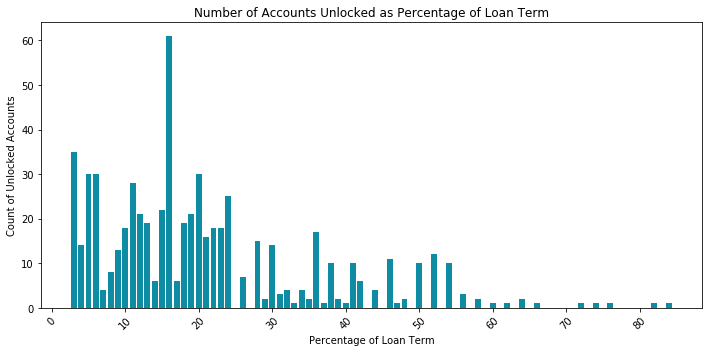

In [18]:
# Create plot
plt.figure(figsize=(10, 5))
plt.bar(data_viz.iloc[:,0],data_viz.iloc[:,1], color='#0e8ca4')

# Format figure
plt.title("Number of Accounts Unlocked as Percentage of Loan Term")
plt.xlabel("Percentage of Loan Term")
plt.xticks(rotation=45)
plt.ylabel("Count of Unlocked Accounts")

# Save figure
plt.savefig('../Output/Part2/num_accounts_unlocked_as_pct_loan_term.png')

# Show figure
plt.tight_layout()
plt.show()

## Average time to pay price_unlock for each product

In [19]:
# Convert to seconds
pct_loan_term['time_difference'] = pct_loan_term['time_difference'].dt.total_seconds()

In [20]:
# Average time to pay price_unlock for each product
product_mean_std = pct_loan_term.groupby('product_id', as_index=False).agg({'time_difference':['mean','std'],
                                                                       'num_payments':['mean','std']})

# Convert from seconds to days
product_mean_std['time_difference'] = product_mean_std['time_difference']/86400

In [21]:
# Flatten column headers
product_mean_std.columns = ['_'.join(col) for col in product_mean_std.columns.values]

# Rename product_id column
product_mean_std = product_mean_std.rename(columns={'product_id_':'product_id'})

In [22]:
product_mean_std.head()

,product_id,time_difference_mean,time_difference_std,num_payments_mean,num_payments_std
0,1,113.796488,23.586681,18.428571,3.408672
1,2,79.830475,27.171405,13.000000,2.645751
2,3,178.599167,100.056051,27.750000,14.244882
3,4,114.088596,25.268208,18.142857,3.716117
4,5,127.180359,15.346760,19.750000,2.753785


In [23]:
# Export to csv
product_mean_std.to_csv('../Output/Part2/avg_time_to_repay_by_product.csv', index=False)

### Visualize: Average number of days to pay price_unlock for each product

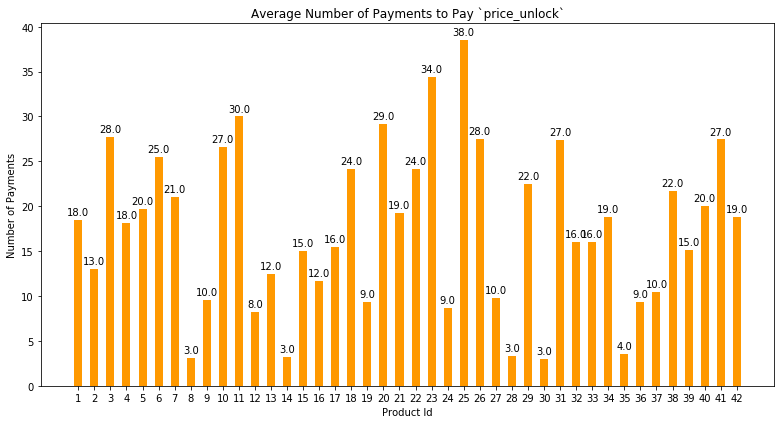

In [24]:
# Set chart values
x_indexes = np.arange(len(product_mean_std['product_id']))
y_means = product_mean_std['num_payments_mean']

# Make figure
plt.figure(figsize=(11,6))
rect1 = plt.bar(x_indexes, y_means, width=0.5, color='#ff9900')

# Format figure
plt.xticks(ticks=range(0, len(x_indexes)),labels=product_mean_std['product_id'])
plt.title('Average Number of Payments to Pay `price_unlock`')
plt.xlabel('Product Id')
plt.ylabel('Number of Payments')

# Create function to label bars
def label_bars(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, height+0.3, round(height),
                ha='center', va='bottom', color="black")

# Call function
label_bars(rect1)

# Save figure
plt.savefig("../Output/Part2/avg_num_payments_to_unlock.png")

# Show figure
plt.tight_layout()
plt.show()

### Most Unlocked Products

In [25]:
# Merge accounts and gpa dataframes
unlocked_products = pd.merge(left=accounts,right=gpa,how='inner',left_on='group_id',right_on='group_id')

In [26]:
# Drop columns
unlocked_products = unlocked_products.drop(columns=['group_id','organization_id','id_y'])

# Drop duplicate rows
unlocked_products = unlocked_products.drop_duplicates()

In [27]:
# Filter for unlocked accounts
unlocked_products = unlocked_products[unlocked_products['is_unlocked']==True]
unlocked_products.head()

,id_x,registration_date,is_written_off,is_unlocked,product_id
0,2,2019-11-06 05:49:39.571392,False,True,42
2,4,2019-12-11 03:18:53.571392,False,True,42
4,6,2019-09-29 13:04:45.571392,False,True,42
5,9,2019-10-10 12:49:10.571392,False,True,42
6,10,2019-12-15 03:38:31.571392,False,True,42


In [28]:
unlocked_products_grouped = unlocked_products.groupby('product_id',as_index=False)['is_unlocked'].count()
unlocked_products_grouped.head()

,product_id,is_unlocked
0,1,7
1,2,3
2,3,4
3,4,7
4,5,4


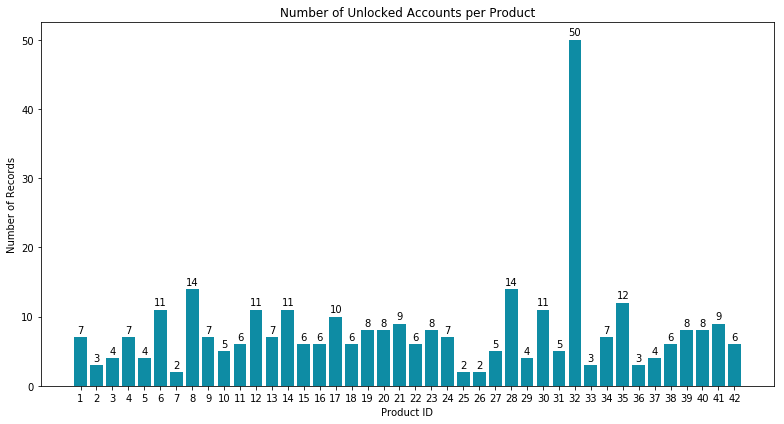

In [29]:
# Set values
x_values = unlocked_products_grouped['product_id']
y_values = unlocked_products_grouped['is_unlocked']

# Make plot
plt.figure(figsize=(11,6))
rect2 = plt.bar(x=x_values, height=y_values, color='#0e8ca4')
plt.xticks(ticks=range(1, len(x_values)+1),labels=x_values)

# Label plot
plt.title('Number of Unlocked Accounts per Product')
plt.xlabel('Product ID')
plt.ylabel('Number of Records')

# Call function
label_bars(rect2)

# Save figure
plt.savefig("../Output/Part2/products_unlocked.png")

# Show figure
plt.tight_layout()
plt.show()